In [300]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [307]:
from carl.distributions import Mixture, MultivariateNormal
p = Mixture(components=[MultivariateNormal(mu=np.array([0., 1.]), sigma=np.eye(2)), 
                        MultivariateNormal(mu=np.array([0., -1.]), sigma=np.eye(2))])
q0 = MultivariateNormal(mu=np.array([1., 0.]), sigma=np.eye(2))
q1 = MultivariateNormal(mu=np.array([-2., 0.]), sigma=np.eye(2))
q2 = MultivariateNormal(mu=np.array([-5., 0.]), sigma=np.eye(2))
q_full = Mixture(components=[q0, q1, q2])

In [308]:
n_samples = 25000

X0 = np.vstack([p.rvs(n_samples), q0.rvs(n_samples)])
y0 = np.zeros(len(X0))
y0[len(X0) // 2:] = 1

X1 = np.vstack([p.rvs(n_samples), q1.rvs(n_samples)])
y1 = np.zeros(len(X1))
y1[len(X1) // 2:] = 1

X2 = np.vstack([p.rvs(n_samples), q2.rvs(n_samples)])
y2 = np.zeros(len(X2))
y2[len(X2) // 2:] = 1

X = np.vstack([X0, X1, X2])
y = np.concatenate([y0, y1, y2])
z = np.zeros(len(X))
z[len(X0):] = 1
z[2*len(X0):] = 2

In [309]:
from keras.utils import np_utils
z = np_utils.to_categorical(z.astype(np.int))

In [310]:
X.shape, y.shape, z.shape

((150000, 2), (150000,), (150000, 3))

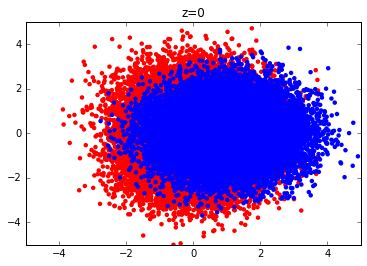

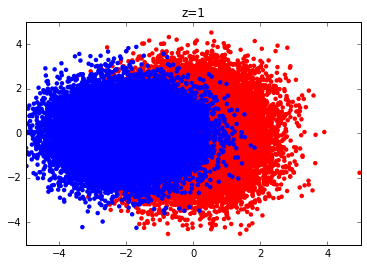

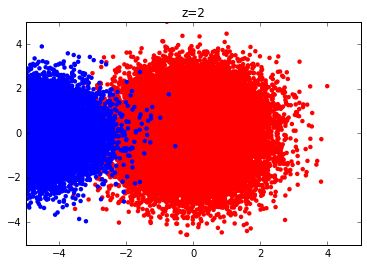

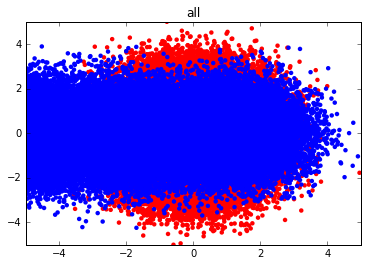

In [311]:
plt.title("z=0")
plt.scatter(X0[y0==0, 0], X0[y0==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X0[y0==1, 0], X0[y0==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

plt.title("z=1")
plt.scatter(X1[y1==0, 0], X1[y1==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X1[y1==1, 0], X1[y1==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

plt.title("z=2")
plt.scatter(X2[y2==0, 0], X2[y2==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X2[y2==1, 0], X2[y2==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

plt.title("all")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

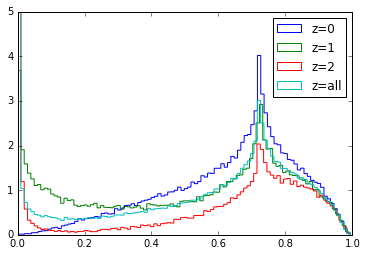

In [312]:
# best model trained on union
d = p.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))
plt.hist(d, bins=100, histtype="step", label="z=0", normed=1)
d = p.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))
plt.hist(d, bins=100, histtype="step", label="z=1", normed=1)
d = p.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))
plt.hist(d, bins=100, histtype="step", label="z=2", normed=1)
d = p.pdf(X) / (p.pdf(X) + q_full.pdf(X))
plt.hist(d, bins=100, histtype="step", label="z=all", normed=1)
plt.legend(loc="best")
plt.ylim(0, 5.)
plt.show()

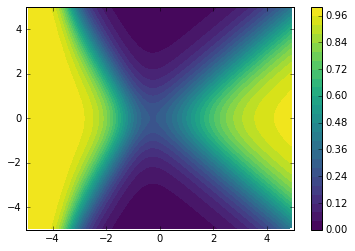

In [313]:
y_pred = q_full.pdf(X_test) / (p.pdf(X_test) + q_full.pdf(X_test))

from matplotlib.mlab import griddata
xi = np.linspace(-5, 5., 100)
yi = np.linspace(-5, 5., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 25, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [351]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(24, activation="relu")(inputs)
Dx = Dense(24, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(24, activation="relu")(Rx)
Rx = Dense(24, activation="relu")(Rx)
Rx = Dense(z.shape[1], activation="softmax")(Rx)
R = Model(input=[inputs], output=[Rx])

In [352]:
R.predict(X[:3])

array([[ 0.34211114,  0.33445361,  0.32343525],
       [ 0.34164554,  0.33439872,  0.32395574],
       [ 0.34207687,  0.33444959,  0.32347354]], dtype=float32)

In [353]:
from keras.optimizers import Adam, SGD
import keras.backend as K

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        y_true = y_true.ravel()
        y_pred = y_pred.ravel()
        return c * ((1.0 - y_true) * (K.log(1.0 - y_pred)) + (y_true) * (K.log(y_pred))) 

    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.categorical_crossentropy(z_pred, z_true)
    
    return loss_R

opt_DRf = SGD(lr=10e-3, momentum=0.1)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=-1.0), 
                  make_loss_R(c=-10.0)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(lr=10e-3, momentum=0.1)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [354]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_26 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_105 (Model)                (None, 1)             697         input_26[0][0]                   
____________________________________________________________________________________________________
model_106 (Model)                (None, 3)             1420        input_26[0][0]                   
Total params: 2117
____________________________________________________________________________________________________


In [355]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_26 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_106 (Model)                (None, 3)             1420        input_26[0][0]                   
Total params: 1420
____________________________________________________________________________________________________


In [356]:
DRf.predict(X[:3])

[array([[ 0.50034839],
        [ 0.47387683],
        [ 0.49839944]], dtype=float32),
 array([[ 0.34211114,  0.33445361,  0.32343525],
        [ 0.34164554,  0.33439872,  0.32395574],
        [ 0.34207687,  0.33444959,  0.32347354]], dtype=float32)]

In [357]:
DfR.predict(X[:3])

array([[ 0.34211114,  0.33445361,  0.32343525],
       [ 0.34164554,  0.33439872,  0.32395574],
       [ 0.34207687,  0.33444959,  0.32347354]], dtype=float32)

In [358]:
# Pretraining
D.trainable = False
R.trainable = True
DfR.fit(X, z, nb_epoch=10)

Epoch 1/10
150000/150000 [==============================] - 1s - loss: 1.0902     
Epoch 2/10
150000/150000 [==============================] - 1s - loss: 1.0276     
Epoch 3/10
150000/150000 [==============================] - 1s - loss: 0.9643     
Epoch 4/10
150000/150000 [==============================] - 1s - loss: 0.9434     
Epoch 5/10
150000/150000 [==============================] - 1s - loss: 0.9316     
Epoch 6/10
150000/150000 [==============================] - 1s - loss: 0.9228     
Epoch 7/10
150000/150000 [==============================] - 2s - loss: 0.9173     
Epoch 8/10
150000/150000 [==============================] - 1s - loss: 0.9148     
Epoch 9/10
150000/150000 [==============================] - 2s - loss: 0.9137     
Epoch 10/10
150000/150000 [==============================] - 2s - loss: 0.9132     


In [361]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.title("iteration = %d" % i)
    
    for label, values in losses.items():
        plt.plot(range(len(values)), values, label=label)
        
    plt.legend(loc="best")
    plt.show()

In [362]:
losses = {"L_d": [], "L_r": [], "L_d - L_r": []}

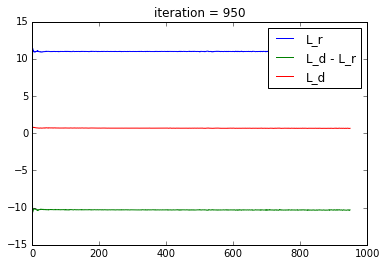

In [363]:
batch_size = 128

for i in range(1000):
    if i % 50 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X))[:batch_size]
    l = DRf.train_on_batch(X[indices], [y[indices], z[indices]])
    
    losses["L_d - L_r"].append(l[0][None][0])
    losses["L_d"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    # Fit R
    D.trainable = False
    R.trainable = True
#     DfR.fit(X, z, nb_epoch=3, verbose=0)
    
    for j in range(100):
        indices = np.random.permutation(len(X))[:batch_size]
        DfR.train_on_batch(X[indices], z[indices])

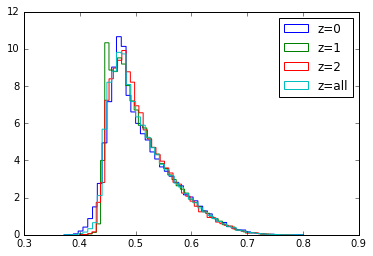

In [364]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="z=0")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="z=1")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="z=2")
plt.hist(1. - D.predict(X), bins=50, normed=1, histtype="step", label="z=all")
plt.legend()
plt.show()

Looks pivotal!

In [365]:
X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.
y_pred = D.predict(X_test).ravel()

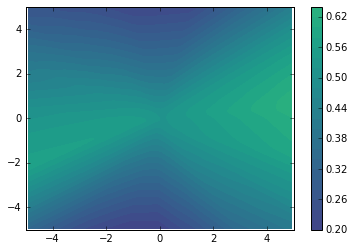

In [366]:
from matplotlib.mlab import griddata
xi = np.linspace(-5, 5., 100)
yi = np.linspace(-5, 5., 200)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 25, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 

In [375]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, D.predict(X0)), 
 roc_auc_score(y1, D.predict(X1)), 
 roc_auc_score(y2, D.predict(X2)), 
 roc_auc_score(y, D.predict(X)))

(0.7178814992, 0.70028603199999995, 0.70124307520000007, 0.70642862355555558)